# Benchmarking results

This document aggregates performance and scaling results for alternative implementations of interval join on Apache Spark library. The experiment aims to find algorithm that scales well with size of the bigger dataset in the join, surpassing driver-centered implementation of _AIList_ algorithm.

## Join algoritms
---
The goal of initial benchmark was to choose interval join implementation to fully measure and optimize. It utilized both synthetic datasets with variable number of rows, as well as databio data as real world example. As reference implementation two different algorithms were used - _driver-ailist_ and _spark-native_, described below.

### Spark native approach - _spark-native_
This is a reference implementation utilizing only Spark's built-in optimizations. It is implemented as full cartesian join followed by filtering operation: 
```sql
lhs CROSS JOIN rhs
WHERE lhs.start >= rhs.end AND rhs.start >= lhs.end
```

### Driver implementation - _driver-ailist_
This is an Augumented Interval List implementation, where the AIList is computed on the driver node, then broadcasted to executors and joined with data there:
```scala
val lhs = lhsDF.collect()
val lhsAIList = spark.broadcast(new AIList(lhs))
val joinedData = rhs.mapPartitions(rhsPartition => join(lhsAIList, rhsPartition)
```
The heavy downside of this approach is limitation of the smaller dataset's size - since AIList is computed on a single node, it does not scale out well. Moreover, Spark's documentation does not encourage performing heavy computation on the driver itself.

### DataFrame cached implementation - _cached-native-ailist_
The DataFrame implementations rely on Spark's native DataFrame operations to compute the AIList. It uses windowing operations to perform AIList items' extraction and iteratively build consecutive components:
```scala
val sourceInputLookaheadWindow = Window
  .partitionBy(KEY, BUCKET)
  .orderBy(FROM, TO)
  .rowsBetween(1, intervalsCountToCheckLookahead)

val preparedDF = sourceDF
  .withColumn("_ailist_lookahead",                    F.collect_list(TO).over(sourceInputLookaheadWindow))
  .withColumn("_ailist_lookahead_overlapping",        F.filter(F.col("_ailist_lookahead"), _ <= F.col(TO)))
  .withColumn("_ailist_lookahead_overlapping_count",  F.size(F.col("_ailist_lookahead_overlapping")))
  .withColumn("_ailist_lookahead_overlapping_keeper", F.col("_ailist_lookahead_overlapping_count") < F.lit(intervalsCountToTriggerExtraction))

val extractedDF  = preparedDF
  .filter(F.col("_ailist_lookahead_overlapping_keeper") === true)
  .withColumn(_COMPONENT, F.lit(iteration))
```
Since the whole algorithm is iterative by nature, this implementation relies on caching to speed up the computation.

### DataFrame storage-backed implementation - _checkpointed-native-ailist_
This algorithm is a modified version of _cached-native-ailist_, where using caching mechanism to optimize execution time is replaced with use of temporary HDFS / local / table to append consecutive components. This limits number of recomputations of already processed rows.

### RDD low-level implementation - _rdd-ailist_
Last implementation uses similar approach to _driver-ailist_, but each AILists are computed in parallel on executors. It is not speeded up by Spark's optimizations, but still should allow for better scaling.

## Algorithms's parameters
Numbers following algorithms' names are parameters for AIList itself;
- _maximumComponentsCount_ - algorithm will not create more components than specified (last component will contain all data not assigned yet),
- _intervalsCountToCheckLookahead_ - specifies size of lookahead window for each row,
- _intervalsCountToTriggerExtraction_ - defines how many overlaps will trigger moving the row out from currently assembled component,
- _minimumComponentSize_ - not used in Spark implementation.

## Datasets
---

### Synthetic data
Synthetic data is made of joins of pairs between two synthetic datasets from the list below. Each generated data row has length described by _IntervalLength_ and is separated from next row by _IntervalMarigin_ value. _IntervalMarigin(0)_ means two consecutive rows have one common point, _IntervalMargin(1)_ - they are separated by width of 1, etc (see comments):
```scala
Array(
    // Point by point: (0, 0), (1, 1), (2, 2)...
    new TestUniform("single-point-continuous", IntervalLength(0), IntervalMargin(1), MAX_TEST_DATASET_SIZE),

    // Point by point, only even numbers: (0, 0), (2, 2), (4, 4)...
    new TestUniform("single-point-even", IntervalLength(0), IntervalMargin(1), MAX_TEST_DATASET_SIZE, TestDataFilter(row => row.from % 2 == 0)),

    // Point by point, only odd numbers: (1, 1), (3, 3), (5, 5)...
    new TestUniform("single-point-odd", IntervalLength(0), IntervalMargin(1), MAX_TEST_DATASET_SIZE, TestDataFilter(row => row.from % 2 == 1)),

    // Short spans, overlap of 2: (0, 10), (5, 15), (10, 20)...
    new TestUniform("short-overlap", IntervalLength(10), IntervalMargin(-5), MAX_TEST_DATASET_SIZE),

    // Short spans, no overlap: (0, 9), (10, 19), (20, 29)...
    new TestUniform("short-continuous", IntervalLength(9), IntervalMargin(1), MAX_TEST_DATASET_SIZE),

    // Short spans, short margins: (0, 9), (20, 29), (40, 49)...
    new TestUniform("short-separated", IntervalLength(9), IntervalMargin(11), MAX_TEST_DATASET_SIZE),

    // Short spans, long margins: (0, 9), (100, 109), (200, 209)...
    new TestUniform("short-sparse", IntervalLength(9), IntervalMargin(91), MAX_TEST_DATASET_SIZE),

    // Long spans, overlap of 2: (0, 10 000), (5 000, 15 000), (10 000, 20 000)...
    new TestUniform("long-overlap", IntervalLength(10000), IntervalMargin(-5000), MAX_TEST_DATASET_SIZE),

    // Long spans, short margins: (0, 9 999), (10 000, 19 999), (20 000, 29 999)...
    new TestUniform("long-continuous", IntervalLength(9999), IntervalMargin(1), MAX_TEST_DATASET_SIZE),

    // Long spans, long margins: (0, 10 000), (20 000, 30 000), (40 000, 50 000)...
    new TestUniform("long-sparse", IntervalLength(10000), IntervalMargin(10000), MAX_TEST_DATASET_SIZE),

    // 1/10 - 1 of domain length
    new TestUniform("sparse-10", IntervalLength(MAX_TEST_DATASET_SIZE.toInt / 10 - 1), IntervalMargin(1), MAX_TEST_DATASET_SIZE),

    // Full domain length
    new TestUniform("sparse-01", IntervalLength(MAX_TEST_DATASET_SIZE.toInt), IntervalMargin(1), MAX_TEST_DATASET_SIZE),

    // Random - normal distribution, single points
    new TestRandomNormal("random-normal-single", IntervalLength(0), MAX_TEST_DATASET_SIZE),

    // Random - normal distribution, short spans
    new TestRandomNormal("random-normal-short", IntervalLength(10), MAX_TEST_DATASET_SIZE),

    // Poisson is too slow, therefore it is set to 1/10 of others

    // Random - poisson distribution, single points
    new TestRandomPoisson("random-poisson-single", IntervalLength(0), MAX_TEST_DATASET_SIZE / 10),

    // Random - poisson distribution, short spans
    new TestRandomPoisson("random-poisson-short", IntervalLength(10), MAX_TEST_DATASET_SIZE / 10),

    // Random - unform distribution, single points
    new TestRandomUniform("random-uniform-single", IntervalLength(0), MAX_TEST_DATASET_SIZE),

    // Random - unform distribution, short spans
    new TestRandomUniform("random-uniform-short", IntervalLength(10), MAX_TEST_DATASET_SIZE),
  )
```

### Synthetics datasets
Synthetic data is used in datasets of following data pairs:
```scala
Array(
    TestDataSuite(
      "one-to-one",
      "test-data/single-point-continuous.parquet",
      "test-data/single-point-continuous.parquet",
      None
    ),
    TestDataSuite(
      "one-to-even",
      "test-data/single-point-continuous.parquet",
      "test-data/single-point-even.parquet",
      None
    ),
    TestDataSuite(
      "odd-to-even",
      "test-data/single-point-odd.parquet",
      "test-data/single-point-even.parquet",
      None
    ),
    TestDataSuite(
      "one-to-long-continuous",
      "test-data/single-point-continuous.parquet",
      "test-data/long-continuous.parquet",
      None
    ),
    TestDataSuite(
      "one-to-long-overlap",
      "test-data/single-point-continuous.parquet",
      "test-data/long-overlap.parquet",
      None
    ),
    TestDataSuite(
      "short-continuous-to-short-overlap",
      "test-data/short-continuous.parquet",
      "test-data/short-overlap.parquet",
      None
    ),
    TestDataSuite(
      "short-continuous-to-long-overlap",
      "test-data/short-continuous.parquet",
      "test-data/long-overlap.parquet",
      None
    ),
    TestDataSuite(
      "short-continuous-to-random-normal-short",
      "test-data/short-continuous.parquet",
      "test-data/random-normal-short.parquet",
      None
    ),
    TestDataSuite(
      "short-continuous-to-random-poisson-short",
      "test-data/short-continuous.parquet",
      "test-data/random-poisson-short.parquet",
      None
    ),
    TestDataSuite(
      "short-continuous-to-random-uniform-short",
      "test-data/short-continuous.parquet",
      "test-data/random-uniform-short.parquet",
      None
    )
)
```

### Databio datasets
The benchmarking also utilized data closer to real-life usage for interval joins - data from [polaris-bio](https://biodatageeks.org/polars-bio/performance/#test-datasets). The partitioned version was used for benchmarking (with 8 partitions):
```scala
Array(
    TestDataSuite(
      "databio-s-1-2",
      "databio-8p/fBrain-DS14718/",
      "databio-8p/exons/",
      None
    ),
    TestDataSuite(
      "databio-s-2-7",
      "databio-8p/exons/",
      "databio-8p/ex-anno/",
      None
    ),
    TestDataSuite(
      "databio-s-1-0",
      "databio-8p/fBrain-DS14718/",
      "databio-8p/chainRn4/",
      None
    ),
    TestDataSuite(
      "databio-m-7-0",
      "databio-8p/ex-anno/",
      "databio-8p/chainRn4/",
      None
    ),
    TestDataSuite(
      "databio-m-7-3",
      "databio-8p/ex-anno/",
      "databio-8p/chainOrnAna1/",
      None
    ),
    TestDataSuite(
      "databio-l-0-8",
      "databio-8p/chainRn4/",
      "databio-8p/ex-rna/",
      None
    ),
    TestDataSuite(
      "databio-l-4-8",
      "databio-8p/chainVicPac2/",
      "databio-8p/ex-rna/",
      None
    ),
    TestDataSuite(
      "databio-l-7-8",
      "databio-8p/ex-anno/",
      "databio-8p/ex-rna/",
      None
    ),
    TestDataSuite(
      "databio-xl-3-0",
      "databio-8p/chainOrnAna1/",
      "databio-8p/chainRn4/",
      None
    )
)
```


## Benchmarking clusters
---
In order to verify scalability of the application in different environments, benchmarking was run on a different Apache Spark clusters:
- spark-worker-m: worker with 4G memory, 4 cores
- spark-worker-l: worker with 10G memory, 10 cores

All clusters were using 4G driver in order to check scalability via changing workers' configuration, not driver's one. 

## Additional notes
---
In order to keep execution time manageable, all benchmark runs were limited in terms of available execution wall time to 30 minutes. Longer attempts were aborted and treated as failed. 

In [1]:
# Following line includes visualization functions.
%run functions.ipynb

# Initial benchmark
---
Initial benchmark has been done in order to choose most promising implementation for replacing _driver-ailist_ implementation. Following results are obtained from running the benchmark application without any data preprocessing or optimization, e.g. repartitioning or bucketing.

## Results and outcome - synthetics
Results are presented on the plots below. Based on that it was decided that:
1. Both _cached-native-ailist_ and _checkpointed-native-ailist_ have unacceptably long execution time, closer to _spark-native_ than to _driver-ailist_ reference implementation. Those applications have been not promoted to further testing.
2. Since the _rdd-ailist_ implementation has execution times comparable to the reference - _driver-ailist_ - implementation of _spark-native_ was also not tested further.

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.


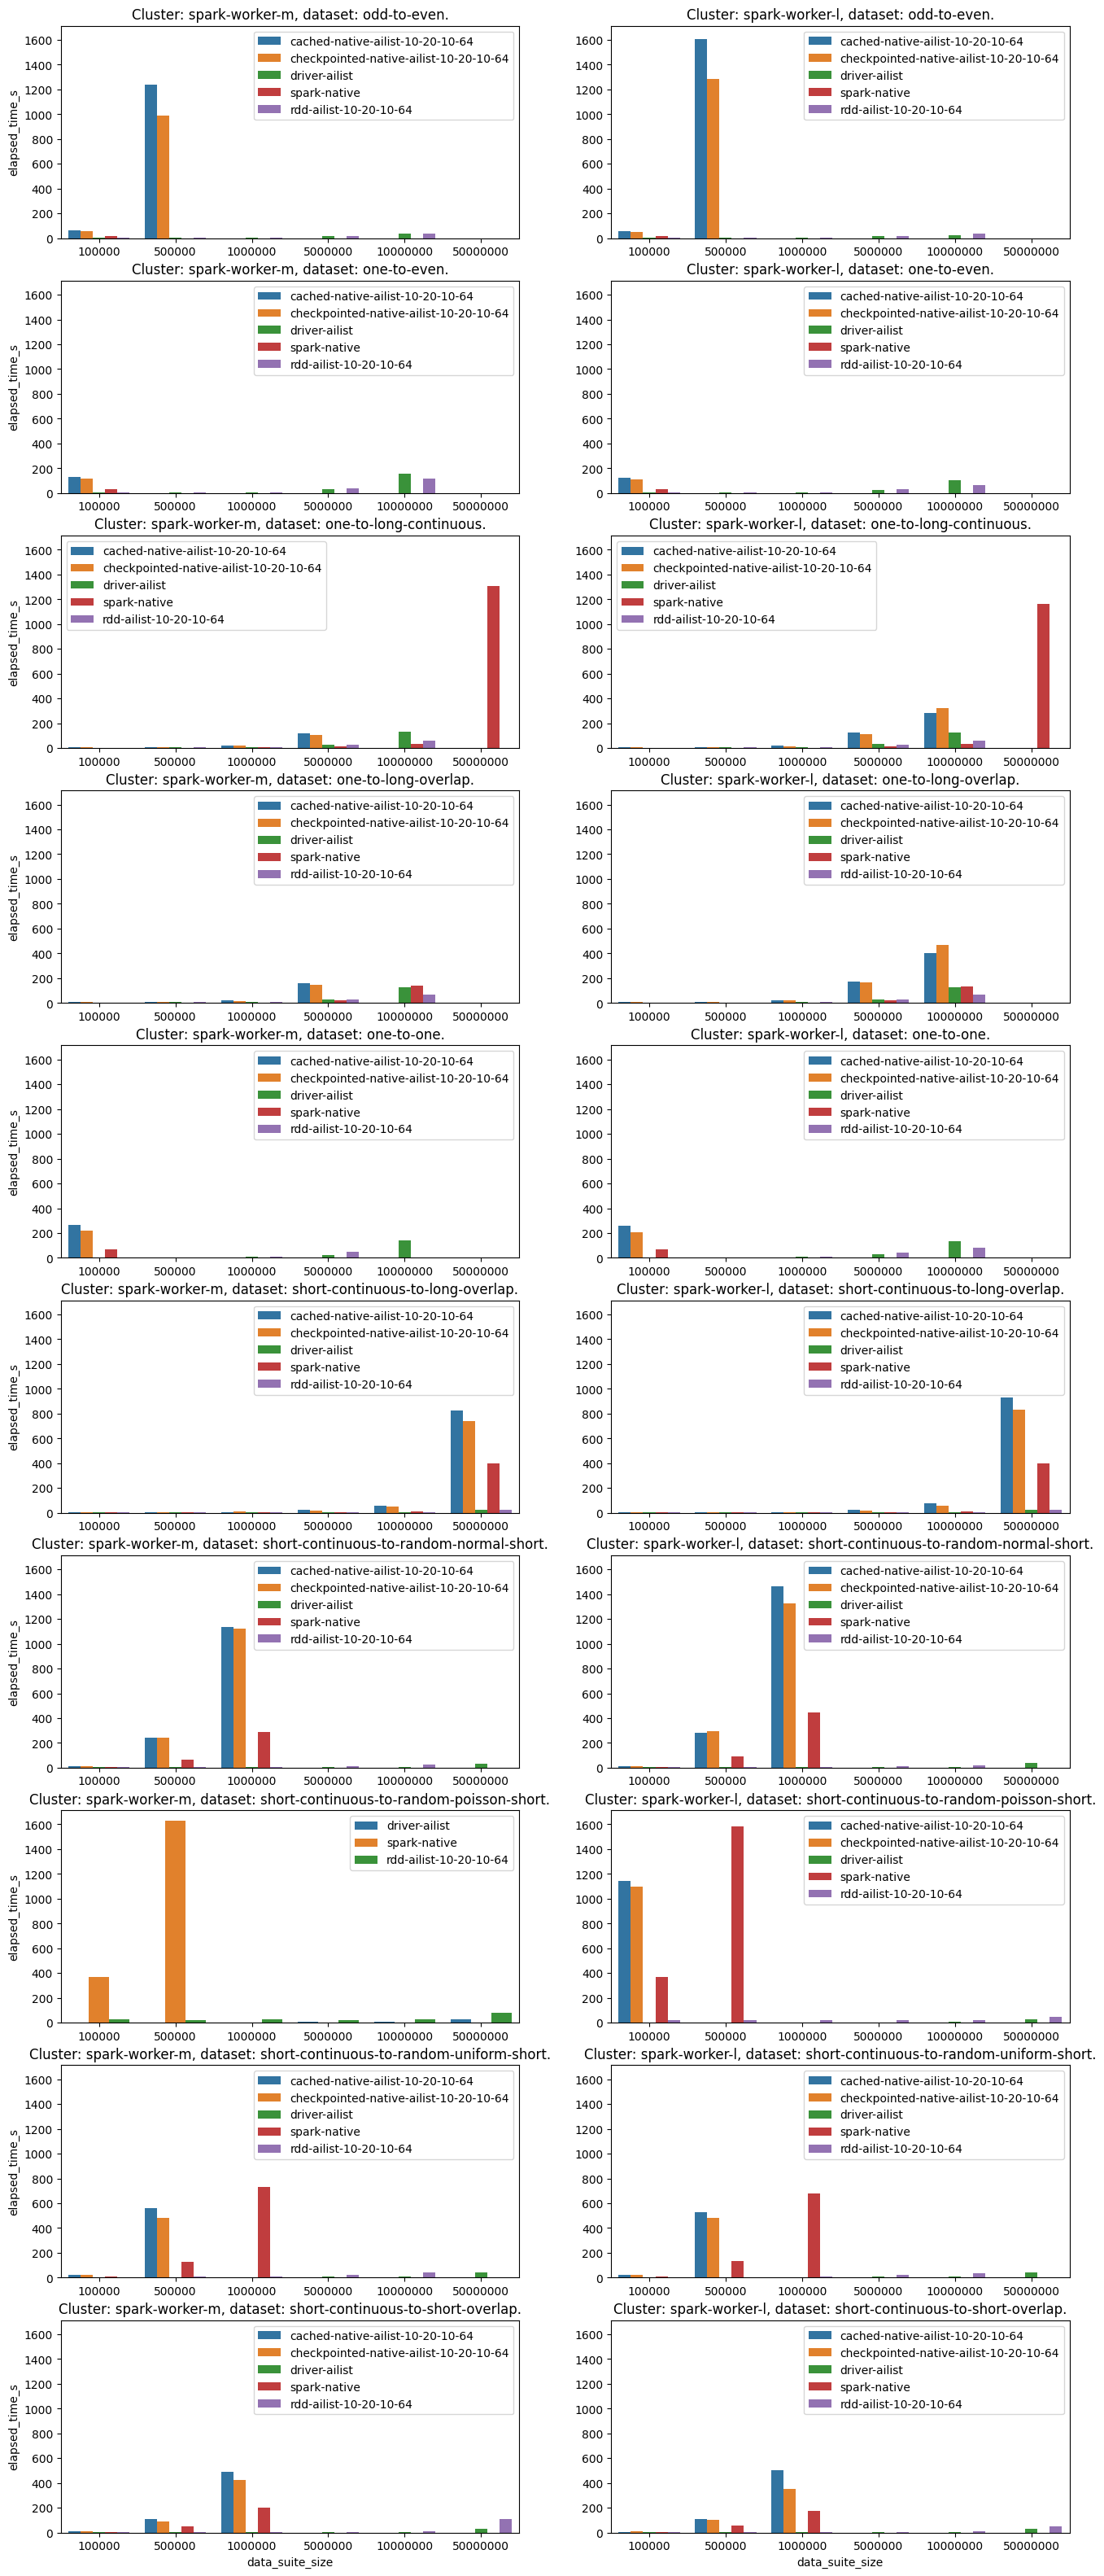

In [2]:
# Plot results for all synthetic datasets, all join implementations.
plot_all_joins_synthetic_benchmark()

## Results and outcome - databio
The results for _databio_ datasets did not differ much from the synthetics' one. It did not collide with decision of removing _native-ai-list_ and _spark-native_ algorithms from further benchmarking.

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.


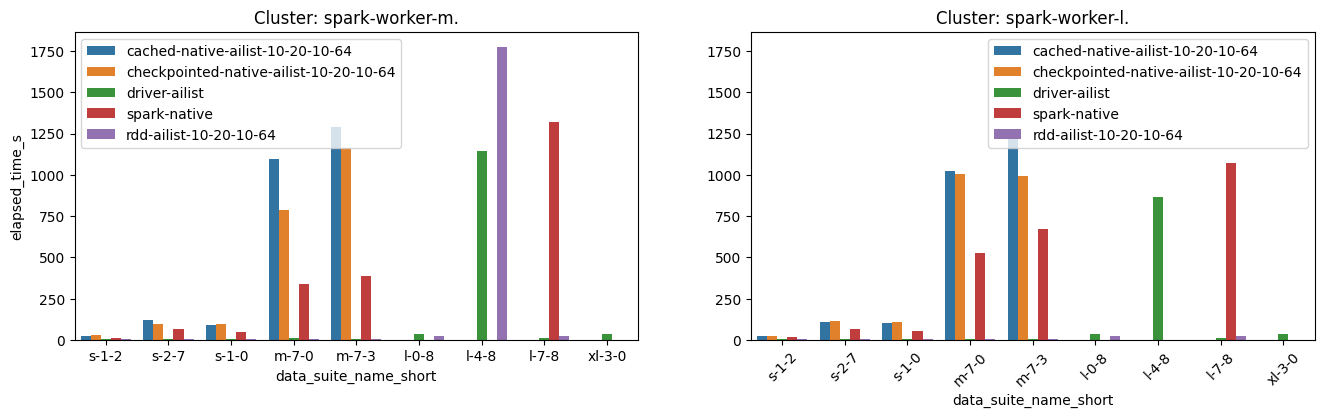

In [3]:
plot_all_joins_databio_benchmark()

# Proposed vs reference benchmark
---
For clarity, charts below contain only _driver-ailist_ and _rdd-ailist_ implementations. Provided default data partitioning, the _rdd-ailist_ does not offer better scaling than the _driver-ailist_ yet, but in some cases it has lower execution times.

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.


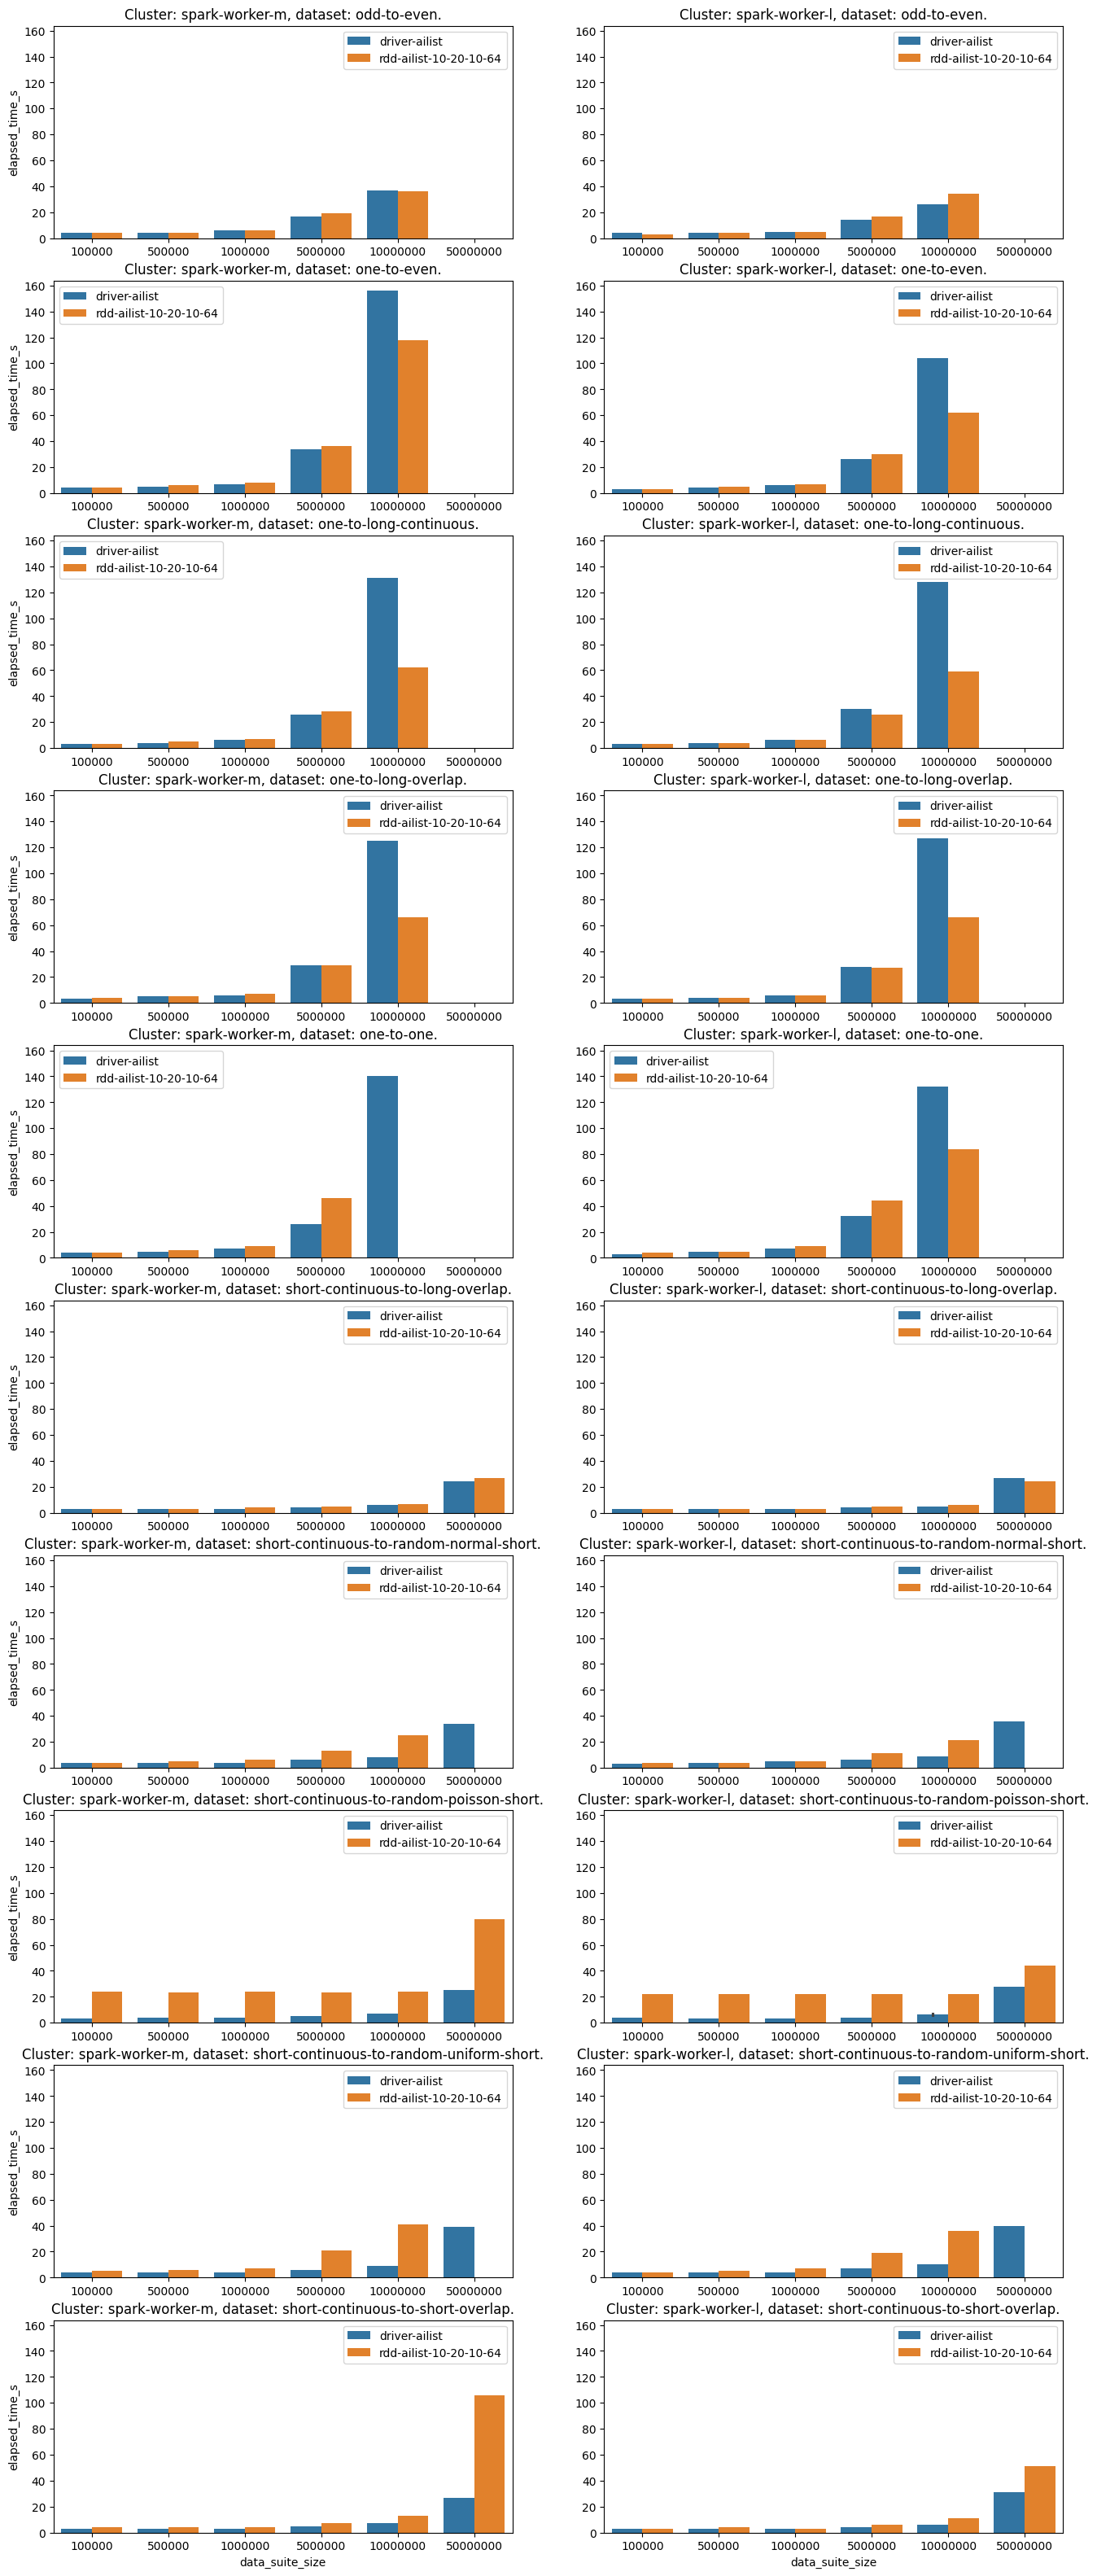

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.


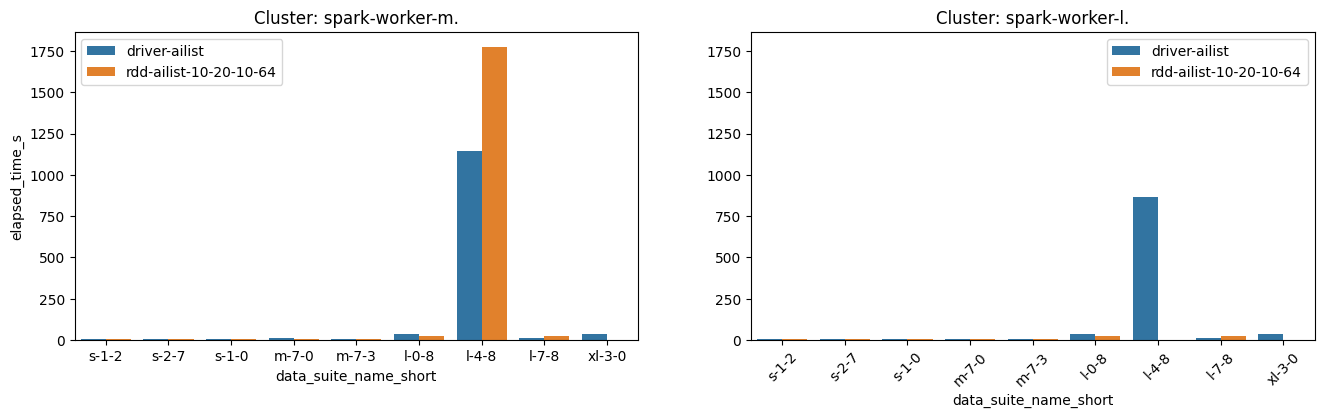

In [4]:
plot_all_joins_synthetic_benchmark(list(["driver-ailist", "rdd-ailist-10-20-10-64"]))
plot_all_joins_databio_benchmark(list(["driver-ailist", "rdd-ailist-10-20-10-64"]))

# Data preprocessing
---
In order to enhance scalability of the _rdd-ailist_, data preprocessing has been introduced. Its aim is to modify partitioning of the data and get rid of the choking points that crash the executors. Two approaches has been tested: bucketing and salting.

## Bucketing
The main goal of bucketizer is to roughly split all data into separate buckets, trying to limit range of possible pairs from whole dataset to a single bucket. It does so by dividing the domain (range of [min(from) ... max(to)] values) into buckets ([a ... b), [b ... c)) and assigning each row to all buckets it covers. Perfect bucketing assigns each row to a single bucket and produces buckets small enough to optimize the join time. 

Bucketing algorithm is defined below; min and max parameters are respectively min(from) and max(to) of all rows in the bigger dataset). Scale parameter is computed from _perRows_ parameter, defined by user: `math.max(1L, datasetCount / perRows)`.

```scala
private lazy val bucketize: UserDefinedFunction =
    F.udf((from: Long, to: Long, min: Long, max: Long, scale: Long) => {
        val normalizedFrom = (from - min) * scale / (max - min)
        val normalizedTo   = ( to  - min) * scale / (max - min)
    
        (normalizedFrom to normalizedTo).toArray
    }
)
```

In case of massive overlapping in the input datasets, bucketing will result with data multiplication and possible degradation of the performance; non-massive scenario may experience better scalability.

## Salting
Salting is a technique meant for more granular distribution of the heavier dataset: one of the datasets is randomly split into _N_ groups, whereas each row of the other one is multiplied _N_ times. This implementation does split both datasets in order to create smaller partitions (although with larger overall number of rows):
```scala
val lhsSalted = input.lhsData
      .withColumn("_bucket_y", F.floor(F.rand() * F.lit(scale)).cast(DataTypes.LongType))
      .withColumn("_bucket_x", F.explode(F.lit((0L until scale).toArray)))
      .withColumn(BUCKET, F.concat_ws(":", F.col(BUCKET), F.col("_bucket_x") * F.lit(scale) + F.col("_bucket_y")))
      .drop("_bucket_x", "_bucket_y")
      .as[BucketedInterval]

val rhsSalted = input.rhsData
      .withColumn("_bucket_x", F.floor(F.rand() * F.lit(scale)).cast(DataTypes.LongType))
      .withColumn("_bucket_y", F.explode(F.lit((0L until scale).toArray)))
      .withColumn(BUCKET, F.concat_ws(":", F.col(BUCKET), F.col("_bucket_x") * F.lit(scale) + F.col("_bucket_y")))
      .drop("_bucket_x", "_bucket_y")
      .as[BucketedInterval]
```

## Data multiplication
Plot below shows number of rows after preprocessing data with given tool. Bucketing has been tested with (10e3, 10e6, 10e9) rows per bucket, salting with (10e6, 10e7, 10e8, 10e9) rows per salting value.

Loading benchmark results from ../results/spark-worker-m/preprocessing.
Loading benchmark results from ../results/spark-worker-l/preprocessing.


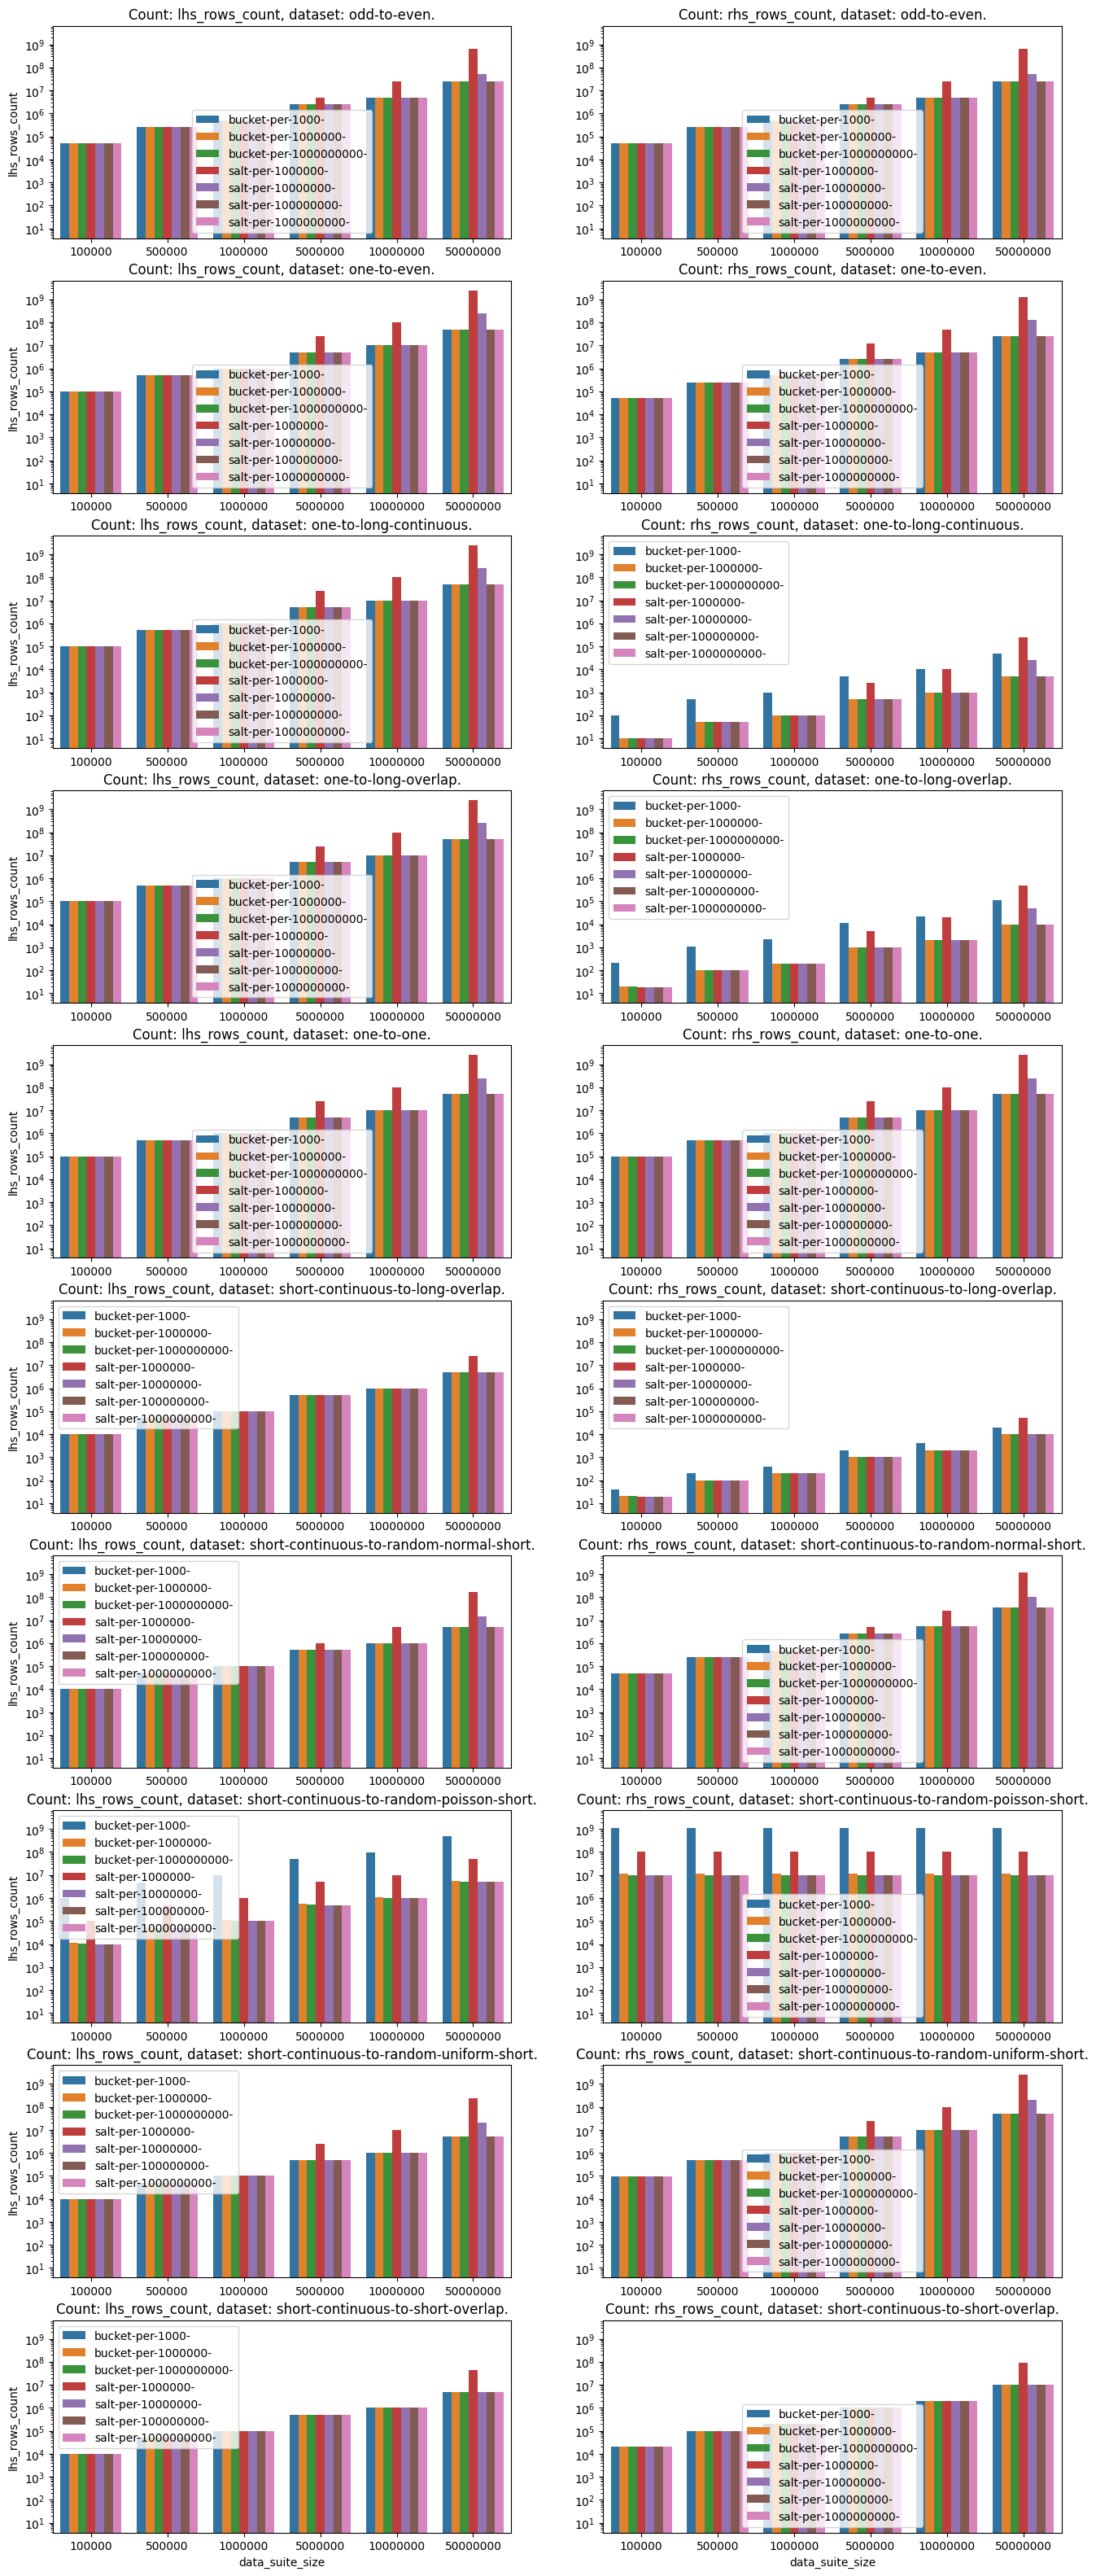

Loading benchmark results from ../results/spark-worker-m/preprocessing.
Loading benchmark results from ../results/spark-worker-l/preprocessing.


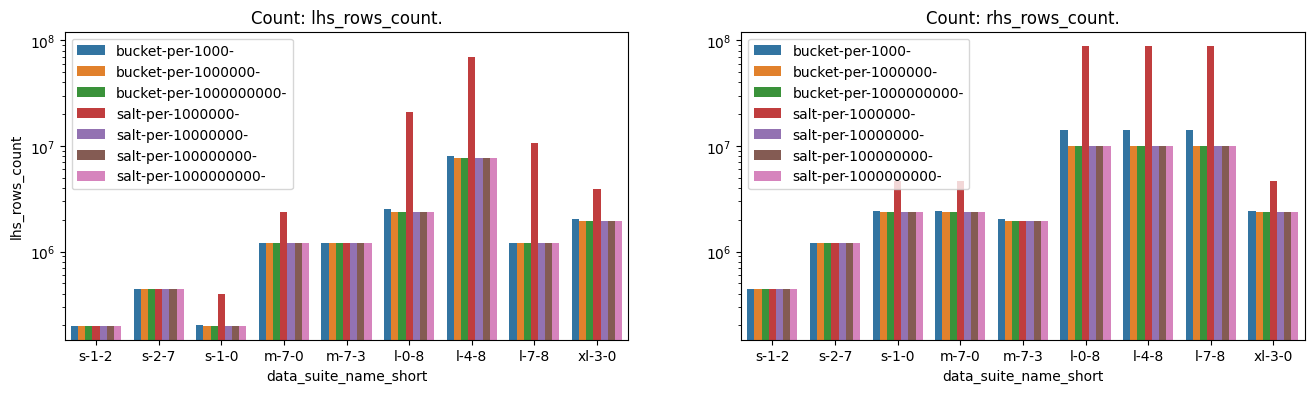

In [5]:
plot_preprocessing_synthetic_benchmark()
plot_preprocessing_databio_benchmark()

# Data preprocessing benchmark 
---
In order to test efficiency of preprocessing the data, the _rdd-ailist_ algorithm has been run with preprocessing step to test both performance and scalability. Since both operations involved shuffle, the desired goal has been defined as a configuration that gives comparable execution time to _driver-ailist_, but better scalability, especially properly executing joins on all of the test data suites. 

## Results
Only bucketing-based realisations have correctly computed all of the joins within reasonable (comparable to _driver-ailist_) time.  

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.
Loading benchmark results from ../results/spark-worker-m/rdd-ailist-partitioning.
Loading benchmark results from ../results/spark-worker-l/rdd-ailist-partitioning.


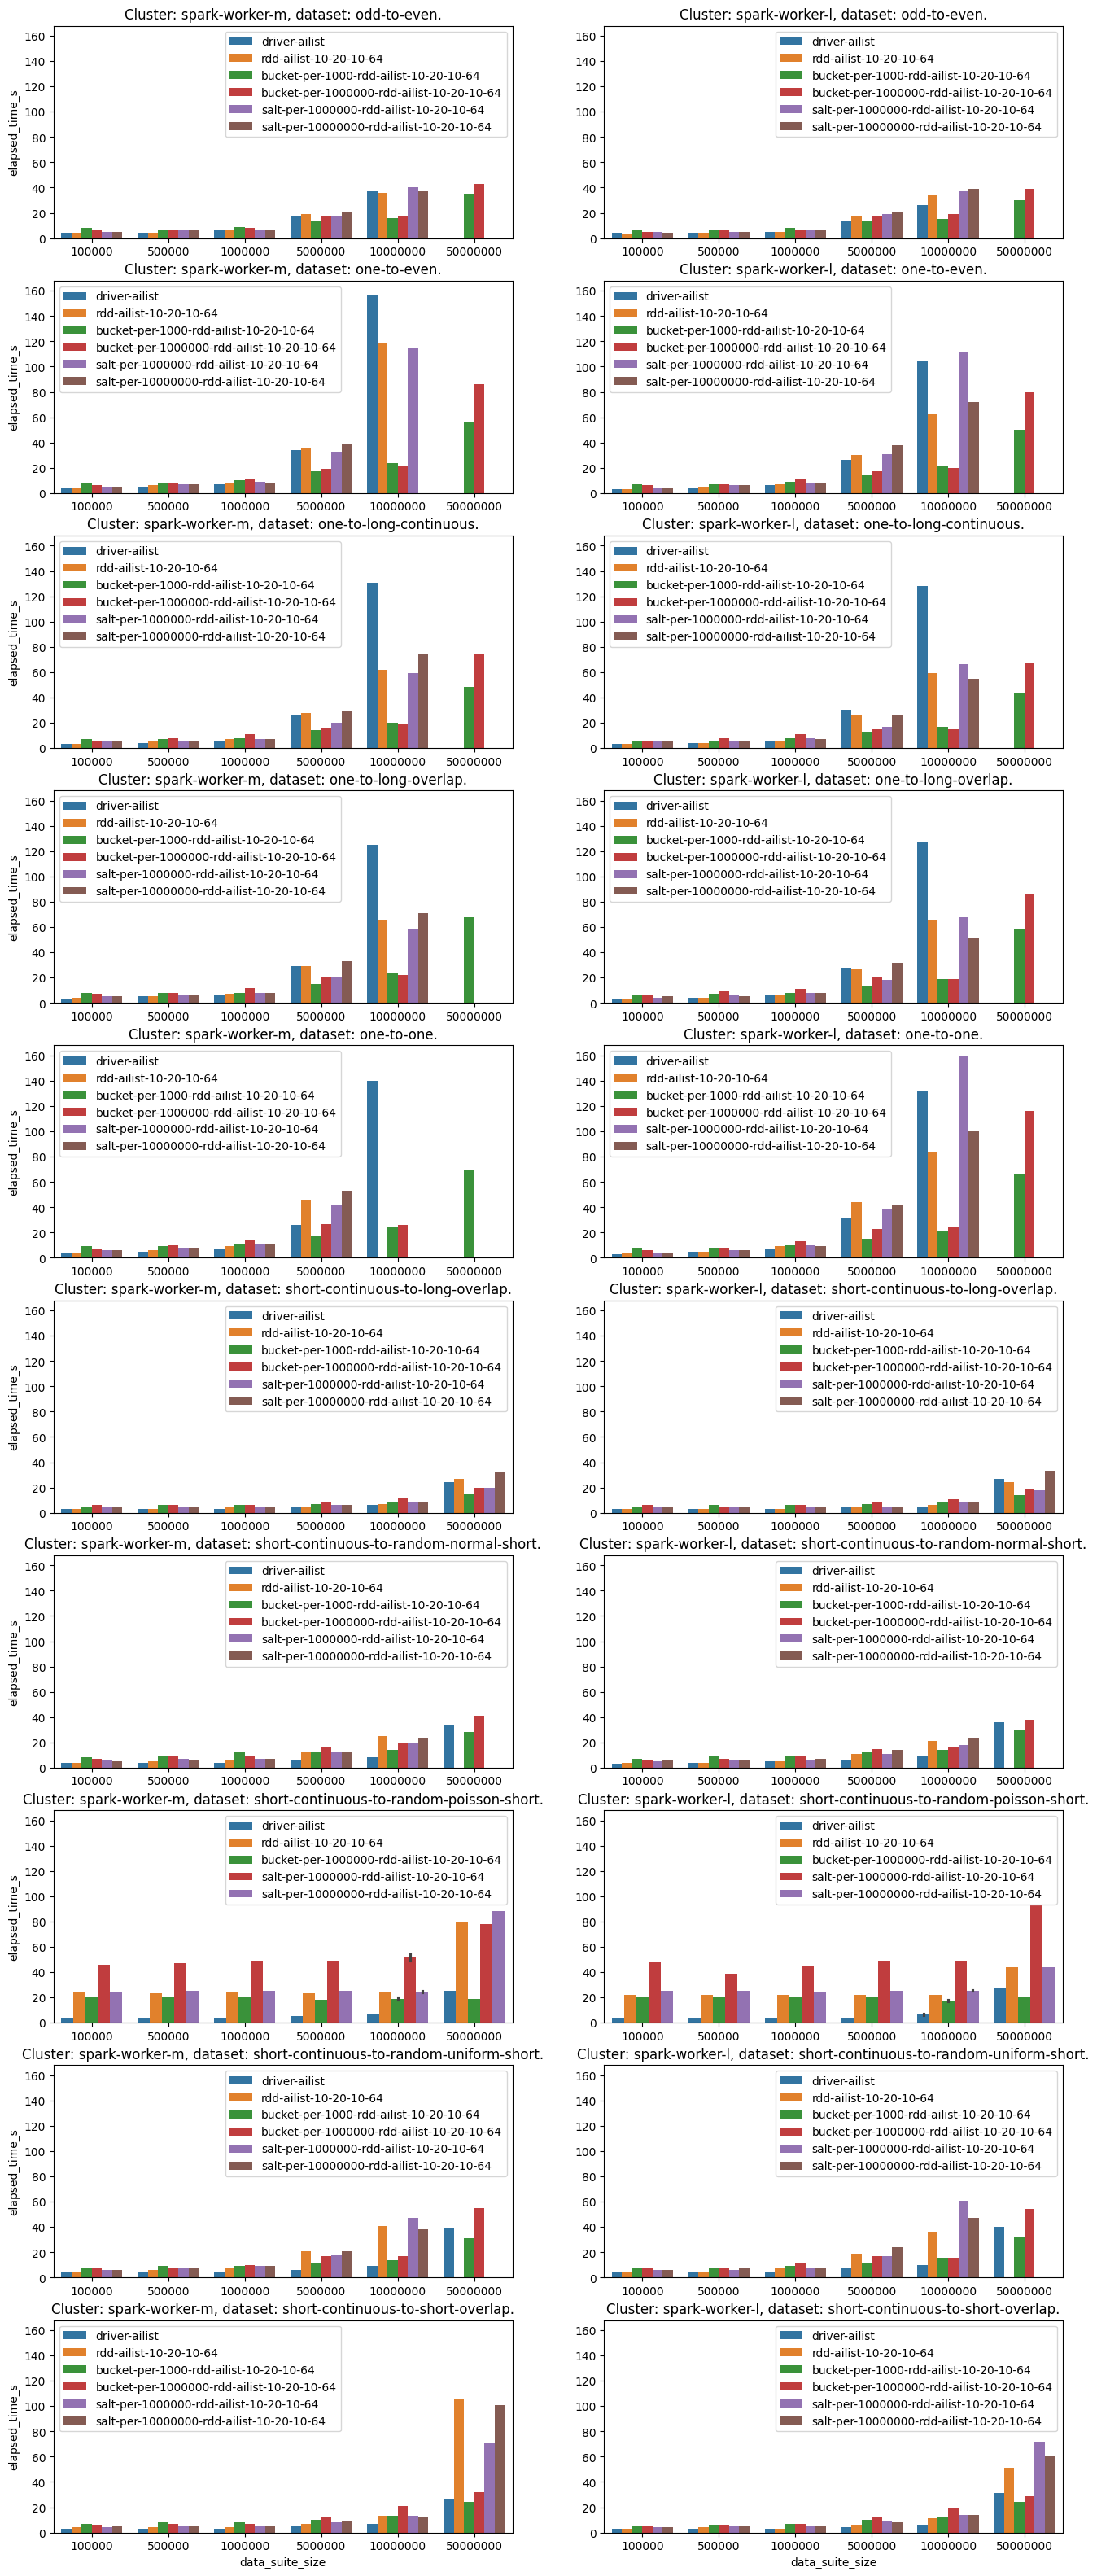

In [6]:
join_names = [
    "bucket-per-1000-rdd-ailist-10-20-10-64",
    "bucket-per-1000000-rdd-ailist-10-20-10-64",
    "salt-per-1000000-rdd-ailist-10-20-10-64",
    "salt-per-10000000-rdd-ailist-10-20-10-64",
    "driver-ailist",
    "rdd-ailist-10-20-10-64"
]
plot_all_joins_synthetic_benchmark(join_names=join_names, directories = ["interval-join", "rdd-ailist-partitioning"])
plot_all_joins_databio_benchmark(join_names=join_names, directories = ["interval-join", "rdd-ailist-partitioning"])

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.
Loading benchmark results from ../results/spark-worker-m/rdd-ailist-partitioning.
Loading benchmark results from ../results/spark-worker-l/rdd-ailist-partitioning.


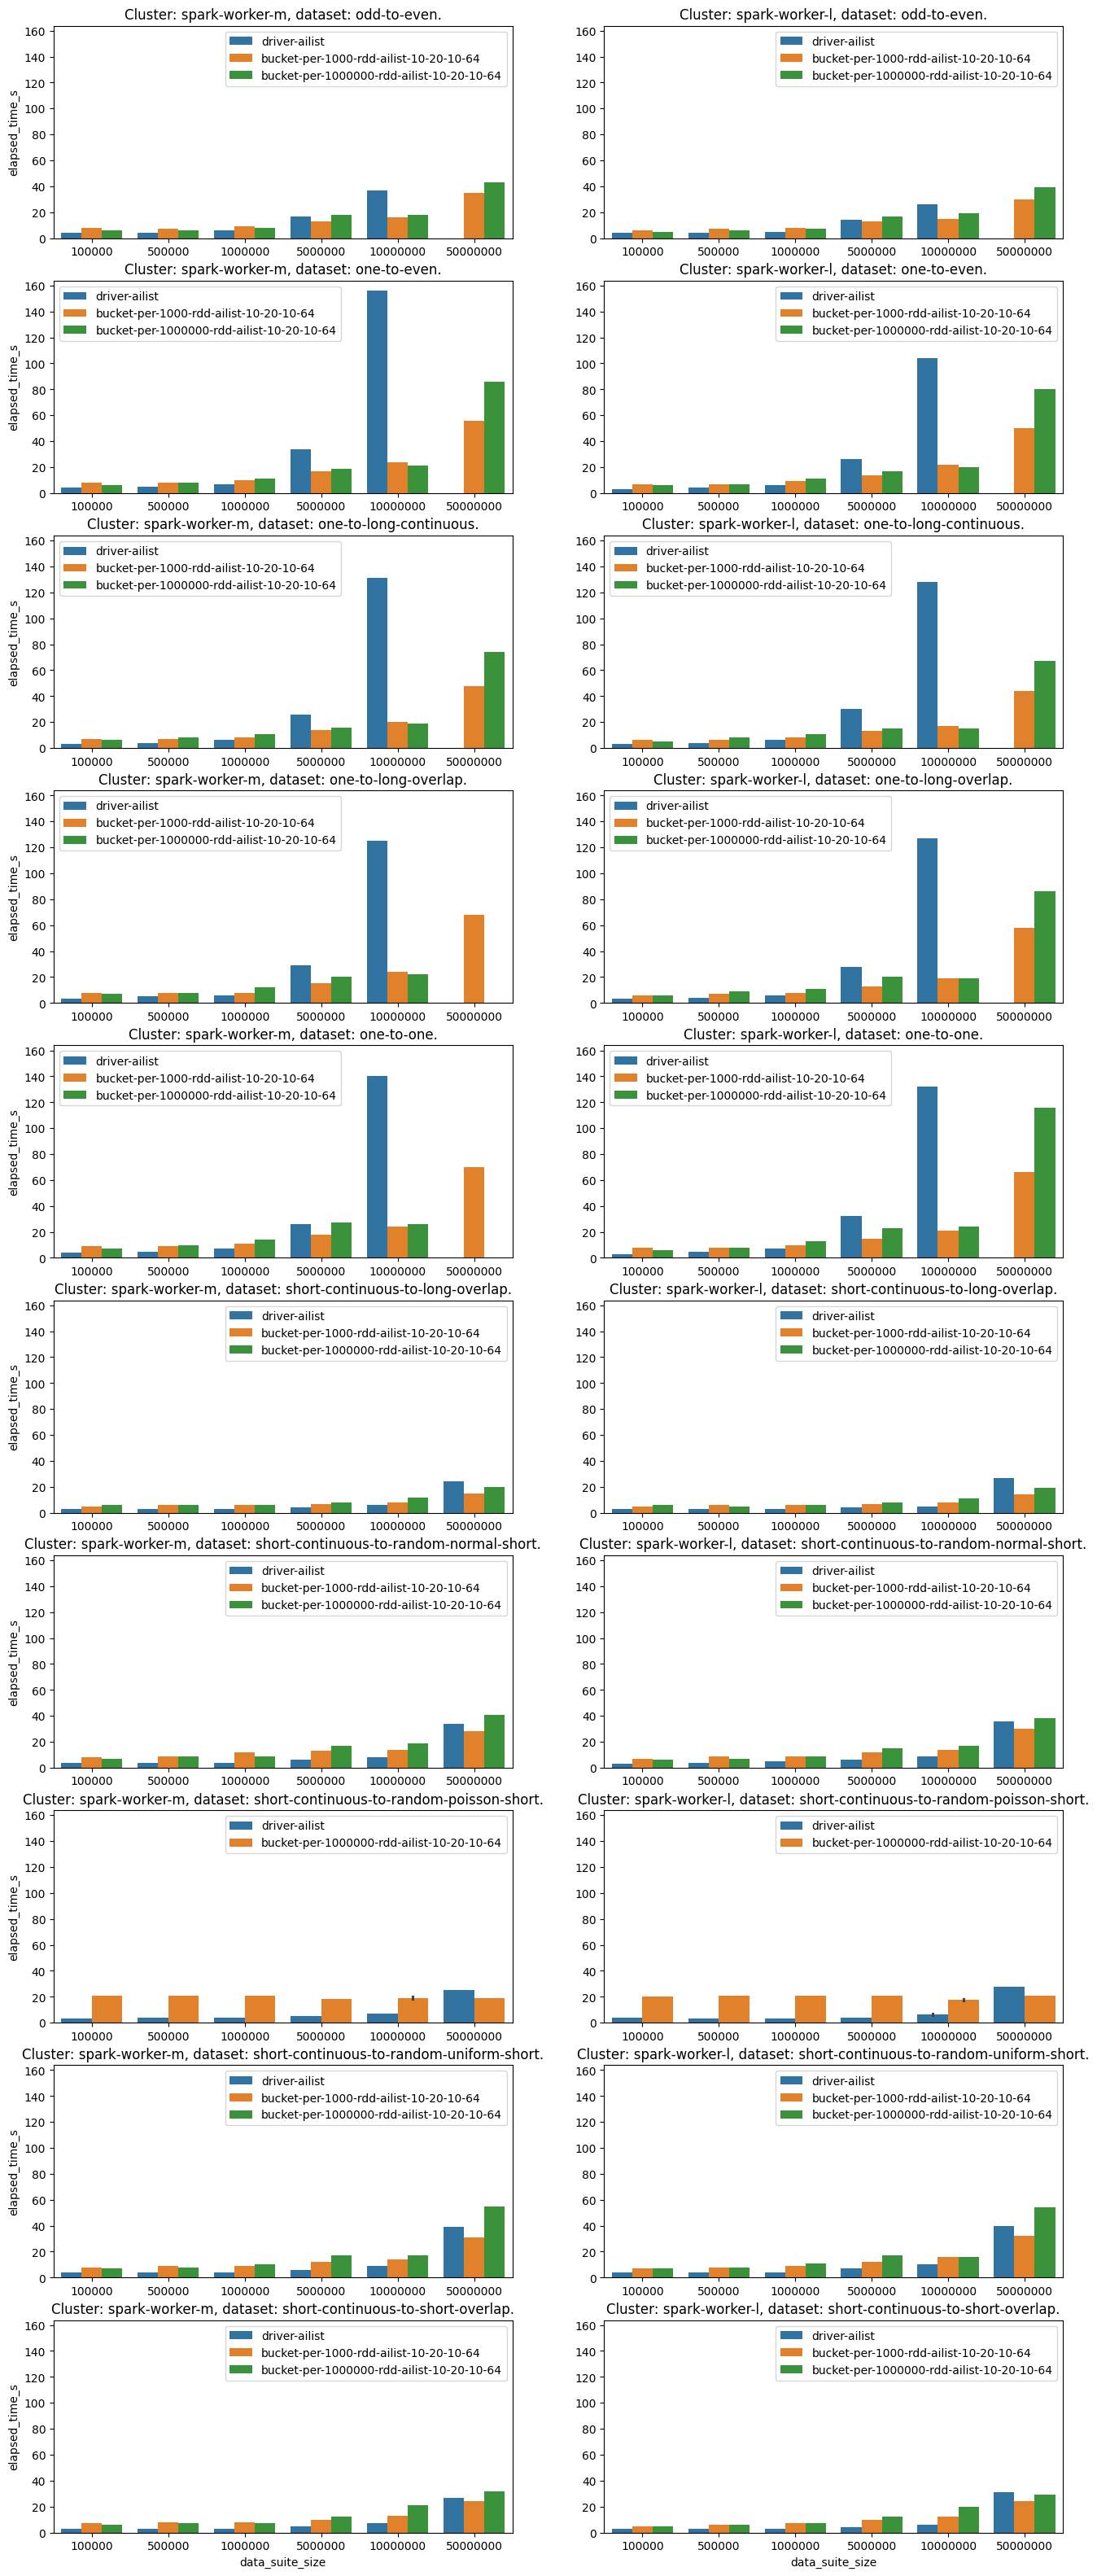

Loading benchmark results from ../results/spark-worker-m/interval-join.
Loading benchmark results from ../results/spark-worker-l/interval-join.
Loading benchmark results from ../results/spark-worker-m/rdd-ailist-partitioning.
Loading benchmark results from ../results/spark-worker-l/rdd-ailist-partitioning.


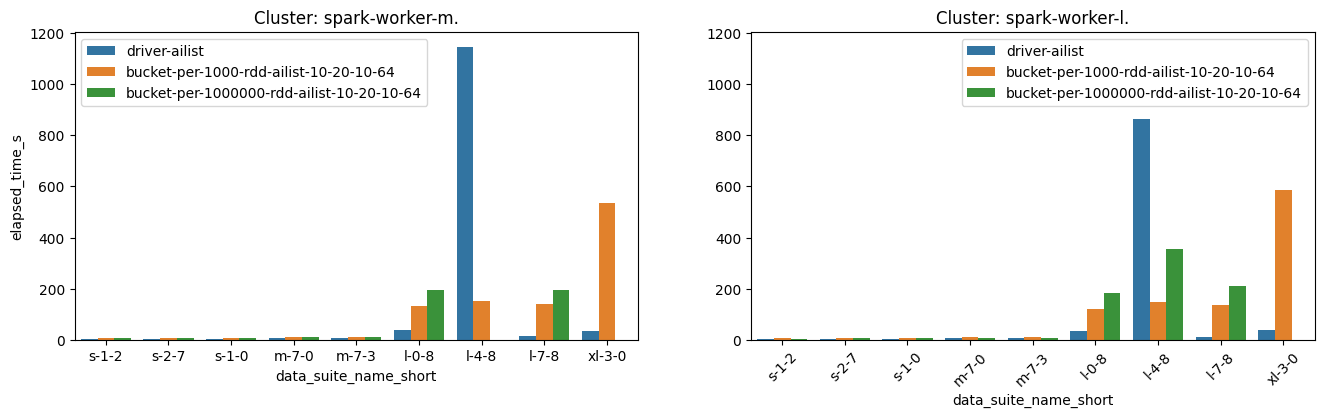

In [9]:
join_names = [
    "driver-ailist",
    "bucket-per-1000-rdd-ailist-10-20-10-64",
    "bucket-per-1000000-rdd-ailist-10-20-10-64"
]
plot_all_joins_synthetic_benchmark(join_names=join_names, directories = ["interval-join", "rdd-ailist-partitioning"])
plot_all_joins_databio_benchmark(join_names=join_names, directories = ["interval-join", "rdd-ailist-partitioning"])

# Further tests and improvements
---
- Study _l-7-8_ and _xl-3-0_ datasets to find the data pattern there, as it may be an easy to reproduce test case for synthetic datasets and further optimize the bucketizer.
- Add a few more _databio_ pairs to test.
- Benchmark the data on _spark-worker-s_ and _spark-worker-xl_ clusters.